In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit,minimize
from scipy.interpolate import UnivariateSpline
import scipy
%matplotlib inline
from tqdm.auto import tqdm
import quaternion as quat

In [2]:
# DEFINE THE COEFFICIENTS FOR USE IN THE CG/RK METHOD

CGRKb = np.array([0.1370831520630755,-0.0183698531564020,
                   0.7397813985370780,-0.1907142565505889,
                   0.3322195591068374]) # b coeffs

CGRKc = np.array([0.0,0.8177227988124852,0.3859740639032449,
                  0.3242290522866937,0.8768903263420429])

CGRKa = np.zeros((5,5))
CGRKa[1:5,0]=[0.8177227988124852,0.3199876375476427,
              0.9214417194464946,0.3552358559023322]
CGRKa[2:5,1]=[0.0659864263556022,0.4997857776773573,
              0.2390958372307326]
CGRKa[3,2] = -1.0969984448371582
CGRKa[4,2:4]=[1.3918565724203246,-1.1092979392113565]


RK4b = np.array([1/6,1/3,1/3,1/6])
RK4c = np.array([0,1/2,1/2,1])
RK4a = np.zeros((4,4))
RK4a[1,0]=1/2
RK4a[2,1]=1/2
RK4a[3,2]=1

In [420]:
def chi2(y1,y2,sy):
    '''
    Compute the Chi2 value.
    '''
    return(np.sum(np.square(x-y)/sy**2))

def ML15(q,earth,a,b,c,sun=[1,0,0]):
    '''
    Compute the M&L lightcurve model.
    '''
    sun = quat.from_vector_part(sun) # turn the sun point to a quaternion
    earth = quat.from_vector_part(earth)
    
    sun   = q *  sun  * q.conj() # compute the sun vectors from rotations
    earth = q * earth * q.conj() # compute the earth vectors from rotations
    
    # get the vector parts of both vector sets
    sun   = quat.as_vector_part(sun) 
    earth = quat.as_vector_part(earth)
    
    C = np.array([1/a**2,1/b**2,1/c**2]) # compute the scaling matrix C
    
    # compute the scaling constants Tsun, Tearth
    Tsun   = np.sqrt(np.einsum('ij,j,ij->i',sun,C,sun))
    Tearth = np.sqrt(np.einsum('ij,j,ij->i',earth,C,earth))
    
    # compute cos(alpha)
    cosa = np.einsum('ij,j,ij->i',sun,C,earth)/(Tearth*Tsun) 
    cosa = np.minimum(cosa,1)
    cosa = np.maximum(cosa,-1)
    
    # compute alpha
    aprime = np.arccos(cosa)
    aprime[np.isclose(aprime,0)]=0
    
    # compute scaling constant T
    T=np.sqrt(np.abs(Tsun**2 + Tearth**2 + 2*Tsun*Tearth*cosa))
    
    # compute cos(lambda) and sin(lambda)
    cosl=np.nan_to_num((Tsun+Tearth*cosa)/T,posinf=0,neginf=0)
    sinl=np.nan_to_num((Tearth*np.sin(aprime))/T,posinf=0,neginf=0)

    # compute the lambda values
    lam=np.where(sinl>=0,np.arccos(cosl),-np.arccos(cosl)%(2*np.pi))
    lam[np.isclose(lam,0,atol=1e-6)]=0
    
    # compute the tan and cotan
    cotl=1/np.tan(lam/2)
    cotal=1/np.tan((aprime-lam)/2)
    
    # compute the M&L brightness
    L = np.where(np.sin(lam)!=0,sinl*np.sin(lam-aprime)*np.log(cotl*cotal),0)
    L += cosl+np.cos(lam-aprime)
    L[np.isclose(L,0)]=0
    L[L!=0] *= (np.pi*a*b*c*Tsun*Tearth/T)[L!=0]
    L[L==0] = 1e-15
    
    return(np.abs(L))

def ellipse_grad(r,a,b,c):
    '''
    Compute the gradient of the ellipse.
    '''
    x,y,z = r
    return((x**2/a**4+y**2/b**4+z**2/c**4)**(-1/2)*np.array([x/a**2,y/b**2,z/c**2]))

def matquatmul(A,q):
    '''
    Compute the matrix multiplication of a 4x4 matrix A and 
    the 4-vector representation of a quaternion q. 
    '''
    assert(A.shape==(4,4))
    return(quat.from_float_array(np.dot(A,quat.as_float_array(q))))

def quatdot(q1,q2):
    '''
    Compute the "quaternion dot product", which is the dot product if the quaternions 
    are in 4-vector form. 
    '''
    return(np.quaternion(np.dot(quat.as_float_array(q1),
                  quat.as_float_array(q2)),0,0,0))

def compMoI(a,b,c,M):
    '''
    Compute the diagonal components of the moment of inertia matrix.
    '''
    return(M/5*np.array([b**2+c**2,a**2+c**2,a**2+b**2]))

def substellarpt(q,a,b,c,sun=[1,0,0]):
    '''
    Compute the sub-stellar point. 
    '''
    C = np.diag([0,a,b,c])
    
    sun = q.conj()*np.quaternion(0,*sun)*q

    norm = np.sqrt(np.norm(matquatmul(C,sun)))
    
    rss = matquatmul(C**2,sun)/norm
    
    if np.abs(matquatmul(np.diag([0,1/a**2,1/b**2,1/c**2]),(q.conj()*rss*q)))<0:
        rss *= -1
    
    return(rss)
    
def comptorque(qp,a,b,c,M=1,A=1):
    '''
    Compute the torque based on the substellar outgassing.
    '''
    rss = substellarpt(qp,a,b,c).vec
    return(M*A*np.quaternion(0,*np.cross(rss,-1*ellipse_grad(rss,a,b,c))))

def CGRK5(q,w,f,dt=1,args=()):
    '''
    Compute the updated qn, wn using a hybrid 
    Crouch-Grossman/Runge-Kutta method in 4th order.
    '''
    
    wi = []
    qi = []
    ki = []
    Ki = []

    for i in range(5):
        wi.append(w+dt*np.sum(ki*CGRKa[i,0:(len(ki))]))
        Ki.append(0.5*wi[i])
        qi.append(np.exp(dt*Ki[i])*q)
        
        ki.append(f(qi[i],wi[i],*args)+k*wi[i]*dt/2)
     
    Ki = np.array(Ki)

    wn = w + dt*np.sum(CGRKb*np.array(ki))#+k*w*dt**2/2
    qn = np.product(np.exp(dt*CGRKb*Ki))*q
    return(qn,wn)

def CGRK5angle(p,w,f,dt,args=()):
    wi = []
    pi = []
    ki = []

    for i in range(5):
        wi.append(w+dt*np.sum(ki*CGRKa[i,0:(len(ki))]))
        pi.append(p+dt*wi[i])
        
        q = np.quaternion(np.cos(pi[i]/2),0,0,np.sin(pi[i]/2))
        qw = np.quaternion(0,0,0,wi[i])
        ki.append(f(q,qw,*args).z)
     

    wn = w + dt*np.sum(CGRKb*np.array(ki))#+k*w*dt**2/2
    pn = p + dt*np.sum(CGRKb*np.array(wi))
    return(pn,wn)

def PCDM(qp0,qw0,compwdot,dt,args):
    '''
    Computes the variables at the relevant time step, as given by Iraz´abal et al. 
    '''
    a,b,c,M,A = args
    wdot0 = compwdot(qp0,qw0,a,b,c,M,A)#+k*qw0*dt/2
    
    qw1 = qw0 + dt/4*wdot0
    qw2 = qw0 + dt/2*wdot0
    
    qw1i = qp0*qw1*qp0.conj()
    qp2 = (qw1i*dt/4).exp()*qp0
    
    qw2i = qp2*qw2*qp2.conj()
    qpn =(qw2i*dt/2).exp()*qp0
    
    wdot2 = compwdot(qpn,qw2,a,b,c,M,A)#+k*qw2*dt/2
    qwn = qw0 + wdot2*dt
    
    return(qpn,qwn)

def PCDMangle(p0,w0,compwdot,dt,args):
    a,b,c,M,A = args
    qp0 = np.quaternion(np.cos(p0/2),0,0,np.sin(p0/2))
    qw0 = np.quaternion(0,0,0,w0)
    wdot0 = compwdot(qp0,qw0,a,b,c,M,A).z#+k*w0*dt/2
    
    w1 = w0 + dt/4*wdot0
    w2 = w0 + dt/2*wdot0
    
    p2 = p0 + w1*dt/2
    
    pn = p0 + w2*dt
    
    qpn = np.quaternion(np.cos(pn/2),0,0,np.sin(pn/2))
    qw2 = np.quaternion(0,0,0,w2)
    wdot2 = compwdot(qpn,qw2,a,b,c,M,A).z#+k*dt*w2/2
    wn = w0 + wdot2*dt
    
    return(pn,wn)

def compwdot(q,w,a,b,c,M,A):
    '''
    Compute the time derivative of the angular velocity, using the torque.
    
    Used in the CG/RK method.
    '''
    Ja,Jb,Jc = compMoI(a,b,c,M)
    
    J = np.diag([1,Ja,Jb,Jc])
    Jinv = np.linalg.inv(J)
    
    w = q.conj()*w*q
    
    Jw = matquatmul(J,w)
    
    term1 = matquatmul(-Jinv,w*Jw)-quatdot(w,Jw)
    term2 = matquatmul(Jinv,comptorque(q,a,b,c,M,A))
    
    return(term1+term2)

def getspacing(xarr,dx=1):
    '''
    Compute a new discrete array with a maximum spacing of dx, 
    and which is a superset of xarr.
    '''
    spacing = np.diff(xarr)
    
    inds = np.where(spacing>=dx)[0]
    
    for i in inds[::-1]:
        xmin,xmax = xarr[i],xarr[i+1]
        npts = int((xmax-xmin)//dx)
        xlist = list(np.linspace(xmin,xmax,npts+2)[1:-1])
        
        xarr[(i+1):(i+1)] = xlist
        
    return(xarr)

def initqp(qw,betai):
    '''
    Compute the initial quaternion position from the initial rotation axis and angle.
    
    Assumes that qw is a pure quaternion with the rotation axis as a vector part.
    '''
    u = qw.vec/np.abs(qw)
    qp = quat.from_rotation_vector(u*betai)
    return(qp)

def initqw(theta,phi,P):
    '''
    Compute the initial pure-quaternion for the rotation axis w. 
    
    theta and phi are the polar and azimuthal angles, and P is the rotation period. 
    '''
    
    qw = np.quaternion(0,np.cos(theta),np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi))
    qw *= 2*np.pi/P
    return(qw)

def compute_model(qp,qw,time,a,b,c,M,A,model='CGRK'):
    '''
    Compute the attitude over time using the torque model.
    '''
    att = [qp]
    angvec = [qw]
    sigma = 1e-1
    
    for dt in np.diff(time):
        qp,qw = globals()[model](qp,qw,compwdot,dt,args=(a,b,c,M,A))
            
        # qw.z += np.random.normal(0,sigma)
        
        att.append(qp)
        angvec.append(qw)
        
    return(np.array(att),np.array(angvec))

In [421]:
def comptorque(qp,a,b,c,M=1,A=1):
    '''
    Compute the torque based on a SHM force. 
    '''
    theta = qp.angle()-np.pi/2
    return(np.quaternion(0,0,0,-A*theta))

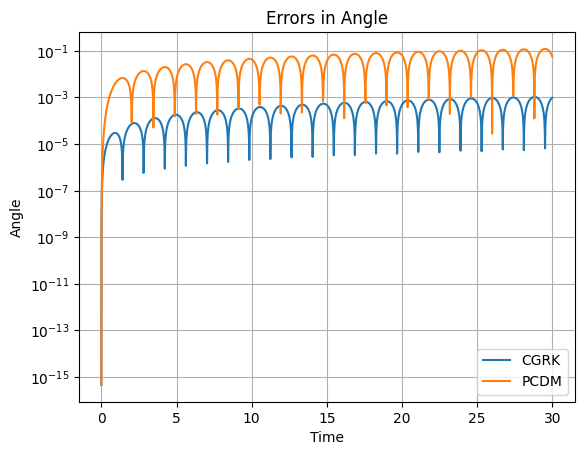

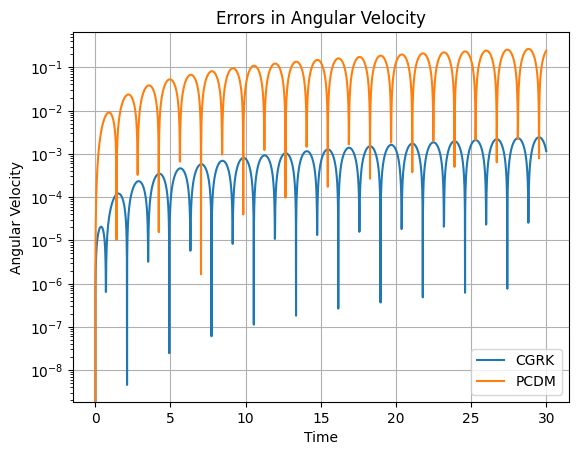

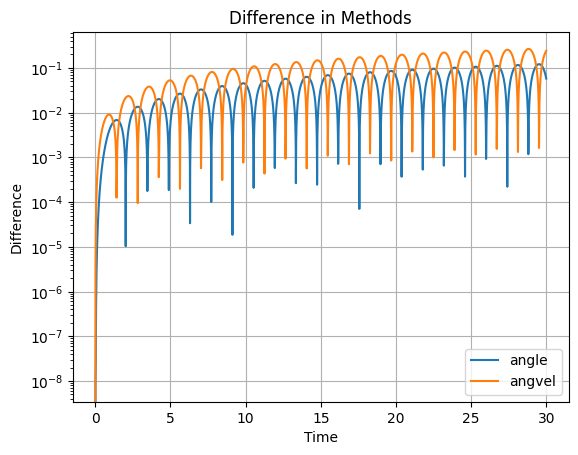

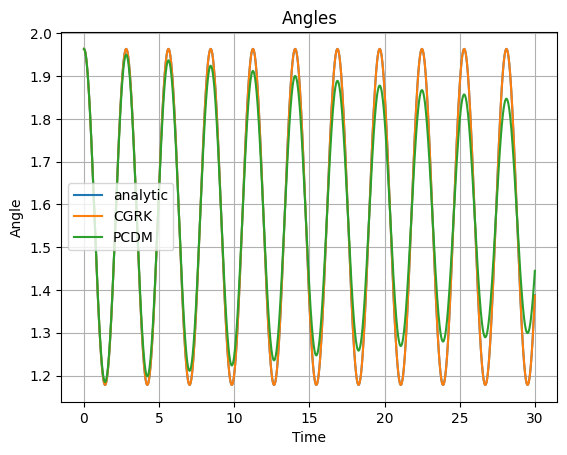

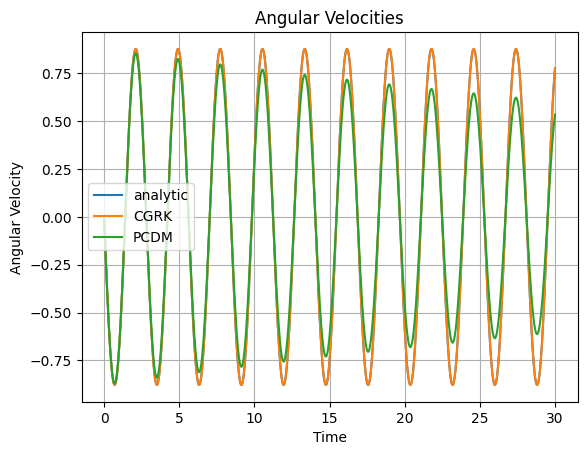

CPU times: user 4.93 s, sys: 5.87 s, total: 10.8 s
Wall time: 3.32 s


In [422]:
%%time

k = 5
dt = 0.01

time = np.arange(0,30,dt)

beta = np.pi*(1/2+1/8)

qp = np.quaternion(np.cos(beta/2),0,0,np.sin(beta/2))
qw = np.quaternion(0,0,0,0)
attPCDM, angvecPCDM = compute_model(qp,qw,time,2,1,1,1,k,model='PCDM')

qp = np.quaternion(np.cos(beta/2),0,0,np.sin(beta/2))
qw = np.quaternion(0,0,0,0) # initial angular velocity quaternion (NOT dqp/dt!). negative for towards the sun
attCGRK, angvecCGRK = compute_model(qp,qw,time,2,1,1,1,k,model='CGRK5')

testangCGRK = [q.angle() for q in attCGRK]
testangPCDM = [q.angle() for q in attPCDM]

# testangCGRK = (testangCGRK-np.pi/2)*np.exp(delta*time)+np.pi/2
# testangPCDM = (testangPCDM-np.pi/2)*np.exp(delta*time)+np.pi/2

testwCGRK = quat.as_float_array(angvecCGRK)[:,3]#*np.exp(delta*time)
testwPCDM = quat.as_float_array(angvecPCDM)[:,3]#*np.exp(delta*time)

trueang = (beta-np.pi/2)*np.cos(np.sqrt(k)*time)+np.pi/2
truew = -(beta-np.pi/2)*np.sqrt(k)*np.sin(np.sqrt(k)*time)

plt.plot(time,np.abs(testangCGRK-trueang),label='CGRK')
plt.plot(time,np.abs(testangPCDM-trueang),label='PCDM')
plt.title("Errors in Angle")
plt.xlabel('Time')
plt.ylabel('Angle')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

plt.plot(time,np.abs(testwCGRK-truew),label='CGRK')
plt.plot(time,np.abs(testwPCDM-truew),label='PCDM')
plt.title("Errors in Angular Velocity")
plt.xlabel('Time')
plt.ylabel('Angular Velocity')
plt.legend()
plt.yscale('log')
plt.grid()
plt.show()

plt.plot(time,np.abs(np.array(testangCGRK)-testangPCDM),label='angle')
plt.plot(time,np.abs(np.array(testwCGRK)-testwPCDM),label='angvel')
plt.yscale('log')
plt.title("Difference in Methods")
plt.xlabel('Time')
plt.ylabel('Difference')
plt.legend()
plt.grid()
plt.show()

plt.plot(time,trueang,label='analytic')
plt.plot(time,testangCGRK,label='CGRK')
plt.plot(time,testangPCDM,label='PCDM')
plt.title("Angles")
plt.xlabel('Time')
plt.ylabel('Angle')
plt.legend()
plt.grid()
plt.show()

plt.plot(time,truew,label='analytic')
plt.plot(time,testwCGRK,label='CGRK')
plt.plot(time,testwPCDM,label='PCDM')
plt.title("Angular Velocities")
plt.xlabel('Time')
plt.ylabel('Angular Velocity')
plt.legend()
plt.grid()
plt.show()

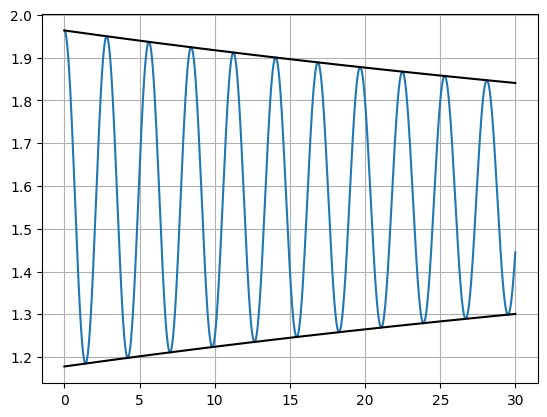

In [423]:
delta = k*dt/4

bounds = (beta-np.pi/2)*np.exp(-delta*time)

plt.plot(time,testangPCDM)
plt.plot(time,bounds+np.pi/2,c='k')
plt.plot(time,-bounds+np.pi/2,c='k')
plt.grid()
plt.show()

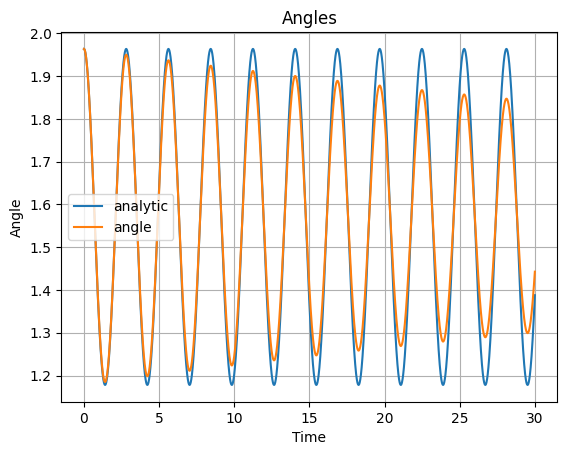

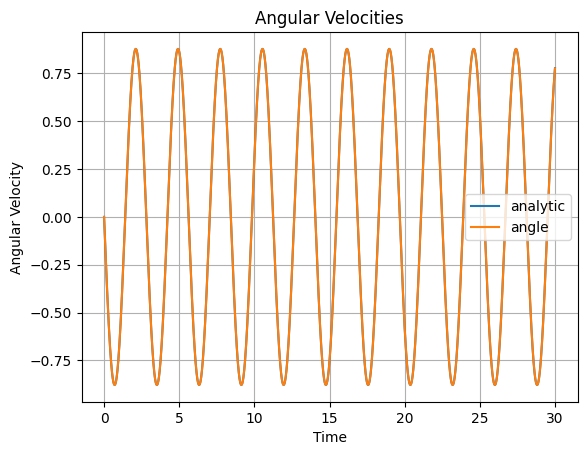

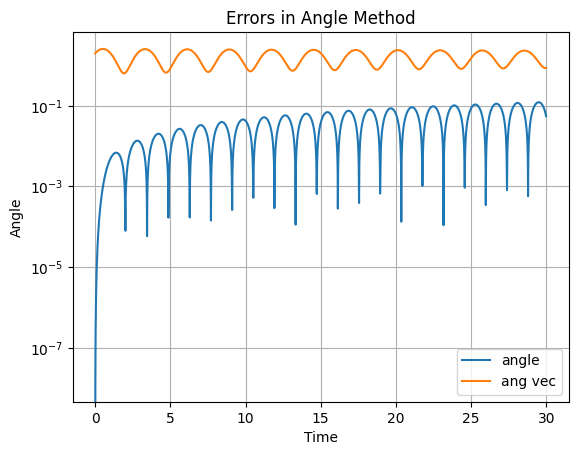

In [424]:
angpure,wpure = compute_model(beta,0,time,2,1,1,1,k,model='CGRK5angle')

plt.plot(time,trueang,label='analytic')
plt.plot(time,angpure,label='angle')
plt.title("Angles")
plt.xlabel('Time')
plt.ylabel('Angle')
plt.legend()
plt.grid()
plt.show()

plt.plot(time,truew,label='analytic')
plt.plot(time,wpure*np.exp(delta*time),label='angle')
plt.title("Angular Velocities")
plt.xlabel('Time')
plt.ylabel('Angular Velocity')
plt.legend()
plt.grid()
plt.show()

plt.plot(time,np.abs(angpure-trueang),label='angle')
plt.plot(time,np.abs(wpure-trueang),label='ang vec')
plt.title("Errors in Angle Method")
plt.xlabel('Time')
plt.ylabel('Angle')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

In [548]:
def RKND(t0,x0,f,butcher,dt=1,args=()):
    
    As,Bs,Cs = butcher
    
    ki = [f(t0,x0,*args)]
    for i in range(1,Cs.size):
        xi = x0 + dt* quat.as_quat_array(
             np.sum(quat.as_float_array(ki)*
             As[i,:len(ki)][:,None,None],0))
        ki.append(f(t0+dt*Cs[i],
                    xi,
                   *args))
        
    tn = t0+dt
    xn = x0+dt*np.sum([q*a for q,a in zip(ki,Bs)],0)
    return(tn,xn)

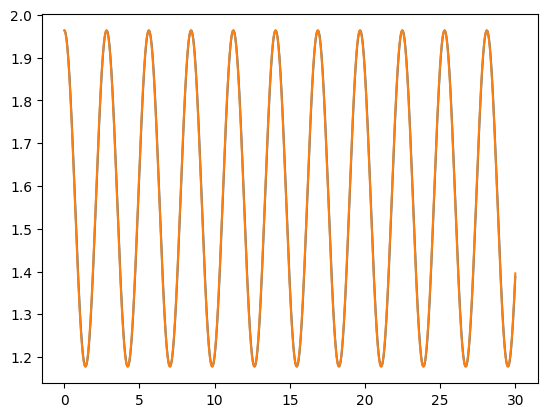

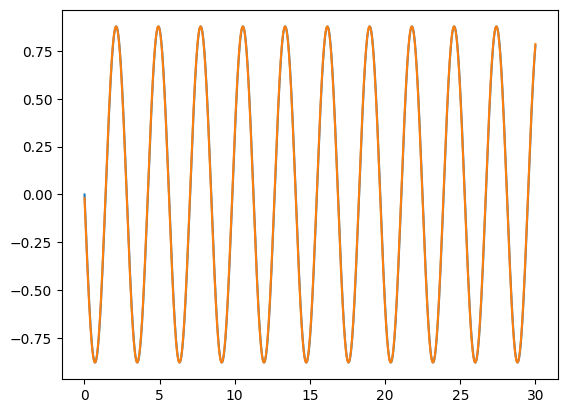

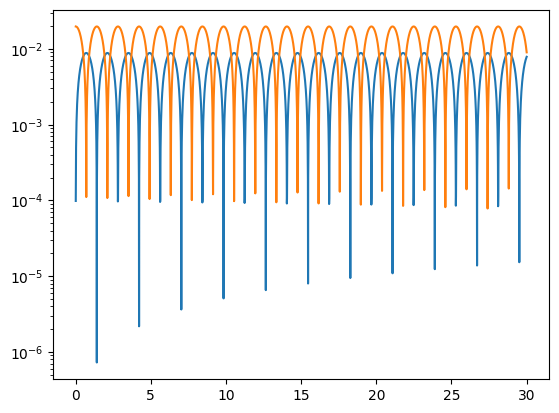

In [551]:
RK4 = (RK4a,RK4b,RK4c)

def deriv(t,x):
    dx0 = 0.5*x[1]*x[0]
    dx1 = compwdot(x[0],x[1],2,1,1,1,k)
    return(np.array([dx0,dx1]))

x = [np.quaternion(np.cos(beta/2),0,0,np.sin(beta/2)),
     np.quaternion(0,0,0,0)]
t = 0

angs = []
wlist = []
time = []

while t<30:
    t,x = RKND(t,x,deriv,RK4,dt)
    x[0]*=1/np.abs(x[0])
    
    time.append(t)
    angs.append(x[0])
    wlist.append(x[1])

    
angs = [q.angle() for q in angs]
wlist = [w.z for w in wlist]
plt.plot(time,trueang)
plt.plot(time,angs)
plt.show()
plt.plot(time,truew)
plt.plot(time,wlist)
plt.show()

plt.plot(time,np.abs(trueang-angs))
plt.plot(time,np.abs(truew-wlist))
plt.yscale('log')
plt.show()
